In [30]:
import tensorflow   #Low level Machine Learning Library
import os   #Operating
import sklearn  #High level ML library similar to Keras
import numpy    # Number Python - lets us do fancy list math
import keras #High level ML library that depends on tensorflow
import matplotlib.pyplot as plt    #Lets us graph stuff 
import pathlib      #Easier to wortk with paths
import collections
import shutil

In [31]:
tensorflow.random.set_seed(41)
numpy.random.seed(41)

DATA_DIR = pathlib.Path("./Fish_Data/images/cropped")
all_images = list(DATA_DIR.glob("*.png"))

def get_species_from_filename(path):
    filename = path.stem
    parts = filename.rsplit('_', 1)
    return parts[0]

species_count = collections.Counter(get_species_from_filename(img) for img in all_images)

In [32]:
ORGANIZED_DIR = pathlib.Path("./Fish_Data/organized/")

if not ORGANIZED_DIR.exists():
    ORGANIZED_DIR.mkdir(parents=True, exist_ok=True)

    for image in all_images:
        species = get_species_from_filename(image)

        species_folder = ORGANIZED_DIR / species
        species_folder.mkdir(exist_ok=True)

        dest_path = species_folder / image.name
        if not dest_path.exists():
            shutil.copy(image, dest_path)

train_dataset = keras.utils.image_dataset_from_directory(ORGANIZED_DIR, validation_split = 0.2, subset="training", seed=42, image_size = (224, 224), batch_size = 32, label_mode = "categorical")

val_dataset = keras.utils.image_dataset_from_directory(ORGANIZED_DIR, validation_split = 0.2, subset="validation", seed=42, image_size = (224, 224), batch_size = 32, label_mode = "categorical")

class_names = train_dataset.class_names
num_classes = len(class_names)

print(class_names)
train_dataset = train_dataset.cache().prefetch(buffer_size=tensorflow.data.AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=tensorflow.data.AUTOTUNE)


Found 4414 files belonging to 484 classes.
Using 3532 files for training.
Found 4414 files belonging to 484 classes.
Using 882 files for validation.
['A73EGS-P', 'CUNWCB-Y', 'Istiophorus_platypterus', 'P1ROZC-Z', 'PQV7DP-S', 'acanthaluteres_brownii', 'acanthaluteres_spilomelanurus', 'acanthaluteres_vittiger', 'acanthistius_cinctus', 'acanthopagrus_australis', 'acanthopagrus_berda', 'acanthopagrus_latus', 'achoerodus_gouldii', 'achoerodus_viridis', 'acreichthys_tomentosus', 'aesopia_cornuta', 'aethaloperca_rogaa', 'alectis_ciliaris', 'alectis_indica', 'alepes_kleinii', 'aluterus_monoceros', 'aluterus_scriptus', 'amanses_scopas', 'anampses_caeruleopunctatus', 'anampses_elegans', 'anampses_femininus', 'anampses_geographicus', 'anampses_lennardi', 'anampses_melanurus', 'anampses_meleagrides', 'anampses_neoguinaicus', 'anampses_twistii', 'anodontostoma_chacunda', 'anyperodon_leucogrammicus', 'aphareus_furca', 'aphareus_rutilans', 'aprion_virescens', 'argyrops_spinifer', 'aseraggodes_melanos

In [33]:
data_augmentation = keras.models.Sequential([
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation(0.1),
    keras.layers.RandomZoom(0.1),
], name="augmentation")

base_model = keras.applications.EfficientNetB0(
    weights="imagenet",
    include_top = False,
    input_shape = (224, 224, 3)
)

base_model.trainable = False

model = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(224, 224,3)),

    data_augmentation,

    base_model,

    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(num_classes, activation='softmax')

], name="fish_classifier")

model.compile(optimizer = keras.optimizers.Adam(learning_rate=0.001),loss = "categorical_crossentropy", metrics=["accuracy"])

C:\Users\coron\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [34]:
callbacks = [keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True), keras.callbacks.ModelCheckpoint("current_fish_model2.keras", monitor = "val_accuracy", save_best_only = True)]

In [25]:
train_history = model.fit(train_dataset, validation_data=val_dataset,epochs=30,callbacks=callbacks)
model.save("fish_model.keras")

Epoch 1/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 51s 413ms/step - accuracy: 0.0297 - loss: 5.9115 - val_accuracy: 0.0873 - val_loss: 5.3790
Epoch 2/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 41s 365ms/step - accuracy: 0.1379 - loss: 4.5593 - val_accuracy: 0.1961 - val_loss: 4.2653
Epoch 3/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 50s 450ms/step - accuracy: 0.2777 - loss: 3.4017 - val_accuracy: 0.2823 - val_loss: 3.5621
Epoch 4/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 39s 349ms/step - accuracy: 0.3712 - loss: 2.6953 - val_accuracy: 0.3152 - val_loss: 3.1566
Epoch 5/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 36s 300ms/step - accuracy: 0.4553 - loss: 2.2557 - val_accuracy: 0.3821 - val_loss: 2.8786
Epoch 6/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 25s 227ms/step - accuracy: 0.4966 - loss: 1.9774 - val_accuracy: 0.3900 - val_loss: 2.7269
Epoch 7/30
 36/111 ━━━━━━━━━━━━━━━━━━━━ 13s 183ms/step - accuracy: 0.5575 - loss: 1.6723

KeyboardInterrupt: 

In [44]:
def predict_fish(image_path, model, show_n=5):
    image = keras.utils.load_img(image_path, target_size=(224,224))
    image_array = keras.utils.img_to_array(image)
    image_array = numpy.expand_dims(image_array, axis=0)

    predictions = model.predict(image_array)
    top_indices = numpy.argsort(predictions[0])[-show_n:][::-1]
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    # Show the image
    axes[0].imshow(image)
    axes[0].set_title("Input Image", fontsize=12)
    axes[0].axis('off')
    
    # Show predictions as bar chart
    species = [class_names[i][:20] for i in top_indices]  # Truncate long names
    probs = [predictions[0][i] * 100 for i in top_indices]
    colors = ['green' if i == 0 else 'steelblue' for i in range(len(species))]
    
    axes[1].barh(range(len(species)), probs, color=colors)
    axes[1].set_yticks(range(len(species)))
    axes[1].set_yticklabels(species)
    axes[1].set_xlabel('Confidence (%)')
    axes[1].set_title('Top Predictions', fontsize=12)
    axes[1].invert_yaxis()
    
    plt.tight_layout()
    plt.show()
    print(f'\nTop {show_n} Predictions')

    # for i, idx in enumerate(top_indices):
    #     print(f"{i+1}. {class_names[idx]}: {predictions[0]}")

    return class_names[top_indices[0]], predictions[0][top_indices[0]]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 988ms/step


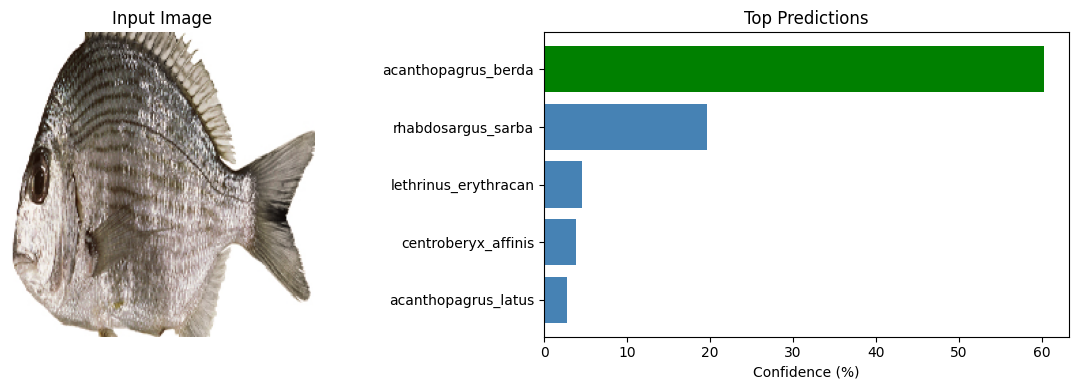


Top 5 Predictions
Wrong Actual Species: rhabdosargus_sarba, Predicted Species: acanthopagrus_berda, Confidence: 0.6031683087348938
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


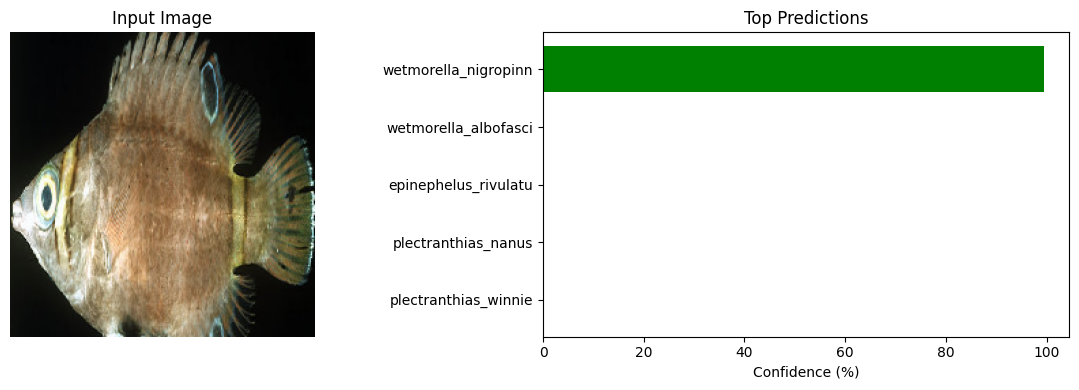


Top 5 Predictions
Correct Actual Species: wetmorella_nigropinnata, Predicted Species: wetmorella_nigropinnata, Confidence: 0.995126485824585
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


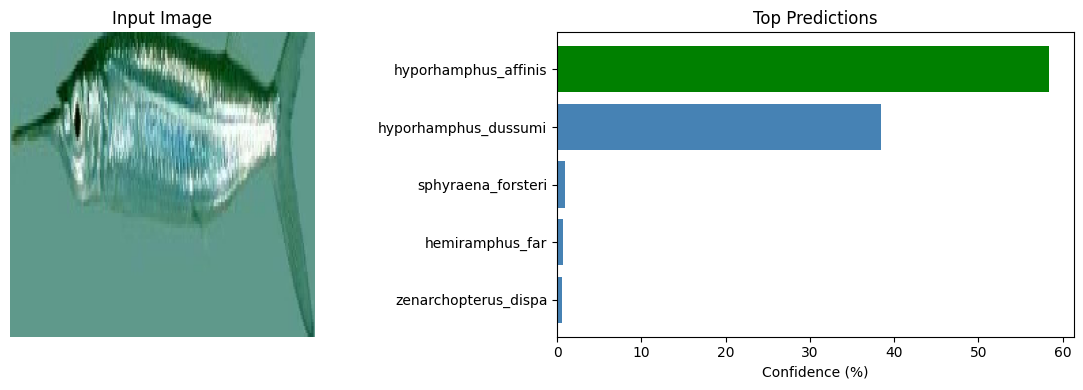


Top 5 Predictions
Wrong Actual Species: hyporhamphus_dussumieri, Predicted Species: hyporhamphus_affinis, Confidence: 0.5839880108833313
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


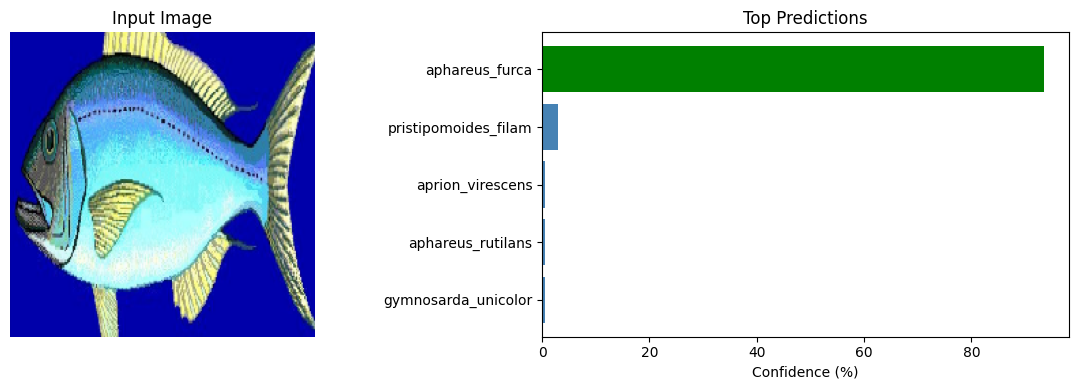


Top 5 Predictions
Correct Actual Species: aphareus_furca, Predicted Species: aphareus_furca, Confidence: 0.9348361492156982
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


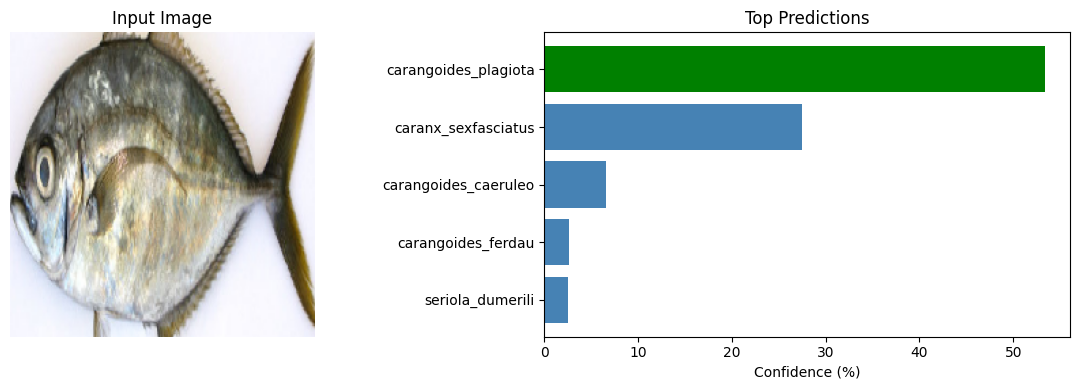


Top 5 Predictions
Correct Actual Species: carangoides_plagiotaenia, Predicted Species: carangoides_plagiotaenia, Confidence: 0.533483624458313
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


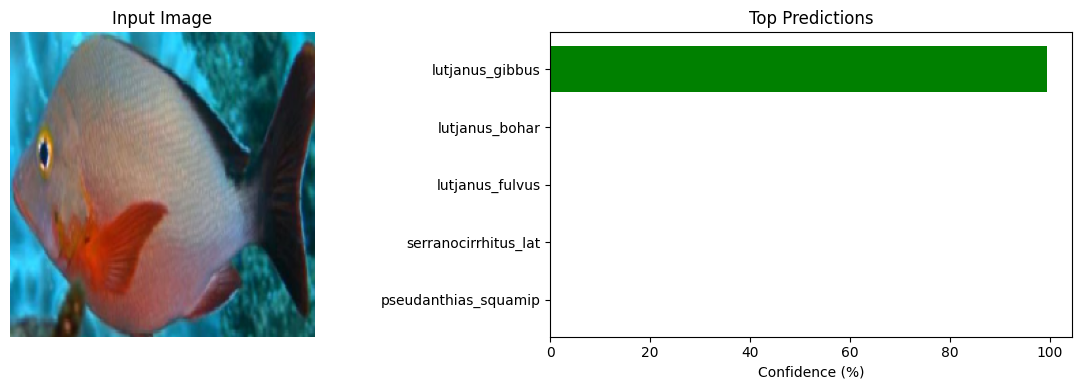


Top 5 Predictions
Correct Actual Species: lutjanus_gibbus, Predicted Species: lutjanus_gibbus, Confidence: 0.9938189387321472
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


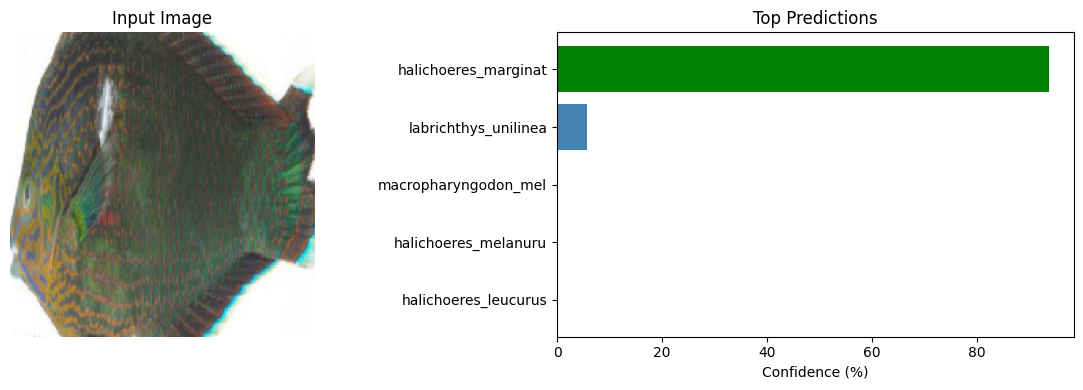


Top 5 Predictions
Correct Actual Species: halichoeres_marginatus, Predicted Species: halichoeres_marginatus, Confidence: 0.9372327327728271
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


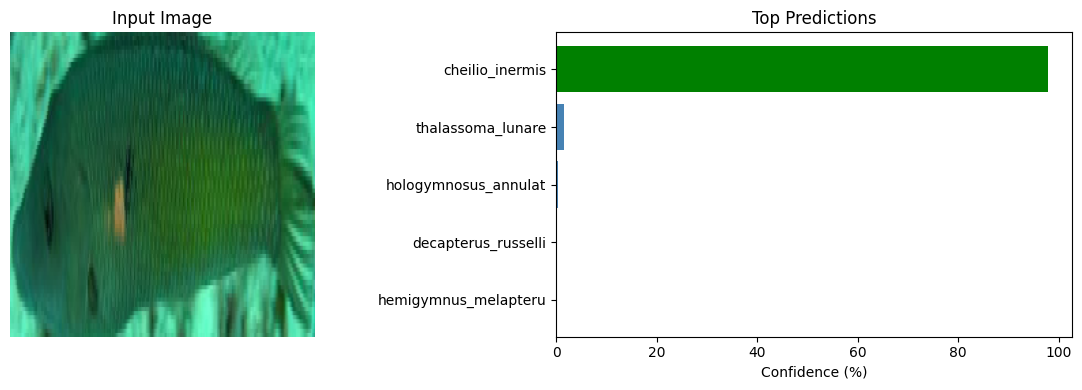


Top 5 Predictions
Correct Actual Species: cheilio_inermis, Predicted Species: cheilio_inermis, Confidence: 0.9780715703964233
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


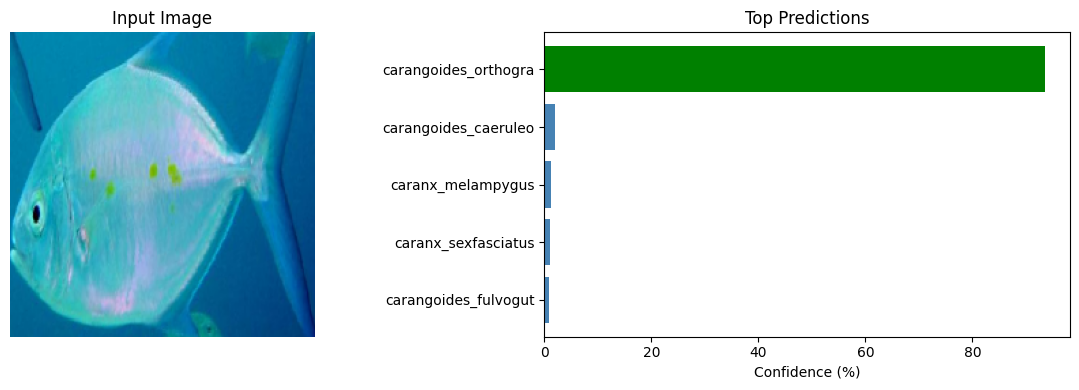


Top 5 Predictions
Correct Actual Species: carangoides_orthogrammus, Predicted Species: carangoides_orthogrammus, Confidence: 0.9351320862770081
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


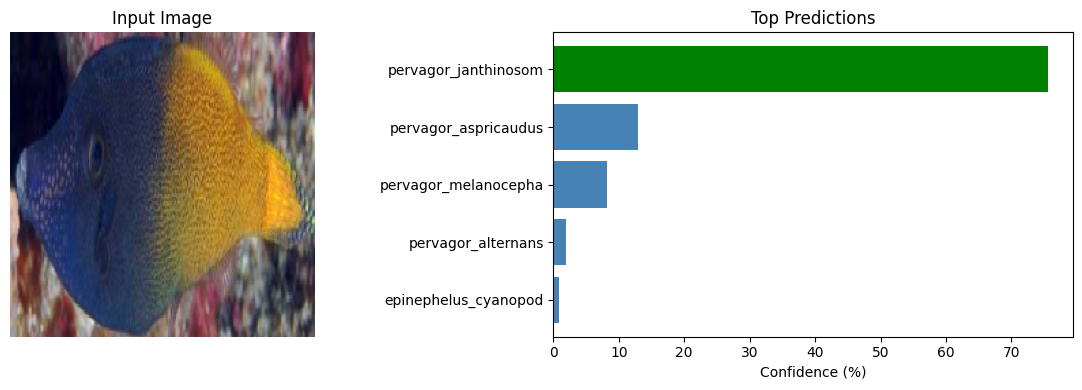


Top 5 Predictions
Correct Actual Species: pervagor_janthinosoma, Predicted Species: pervagor_janthinosoma, Confidence: 0.7558018565177917
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


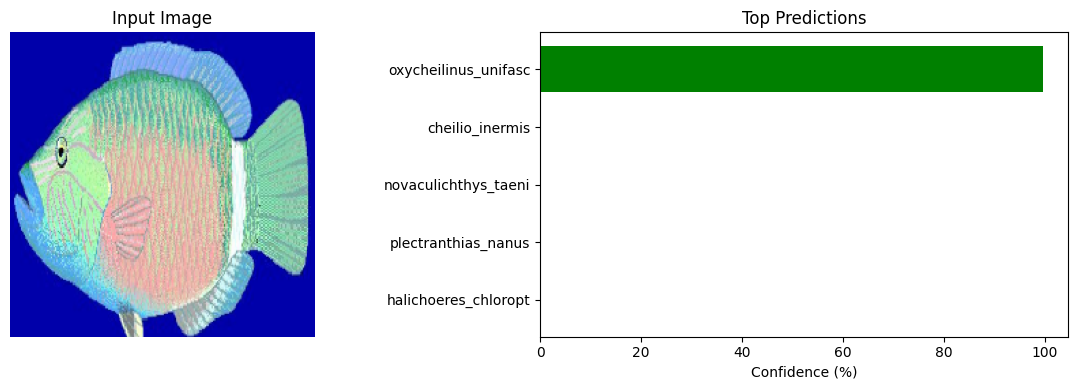


Top 5 Predictions
Correct Actual Species: oxycheilinus_unifasciatus, Predicted Species: oxycheilinus_unifasciatus, Confidence: 0.996781587600708
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


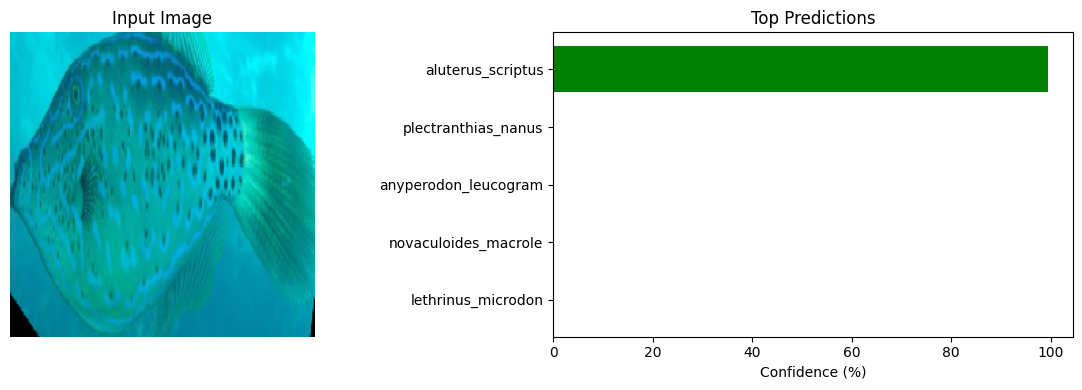


Top 5 Predictions
Correct Actual Species: aluterus_scriptus, Predicted Species: aluterus_scriptus, Confidence: 0.9941589832305908
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


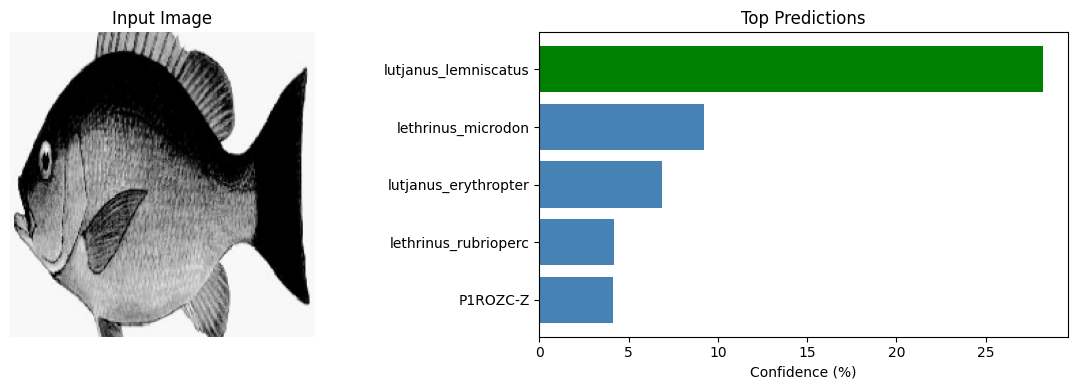


Top 5 Predictions
Wrong Actual Species: lutjanus_erythropterus, Predicted Species: lutjanus_lemniscatus, Confidence: 0.2820504903793335
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


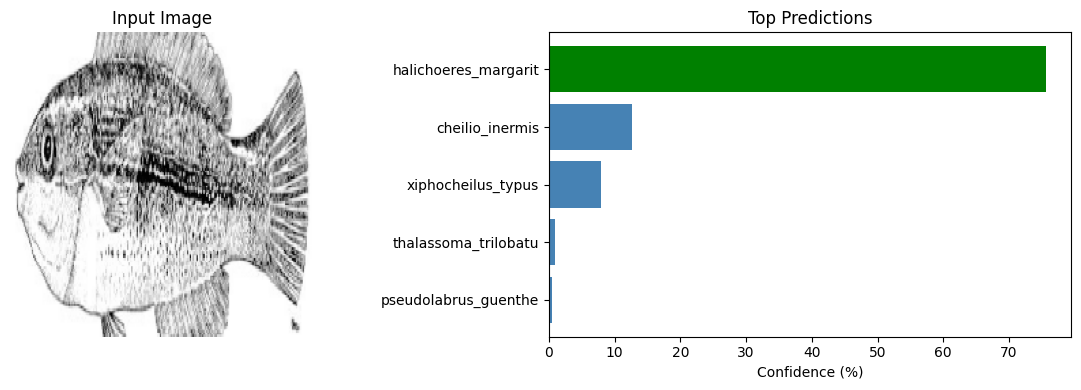


Top 5 Predictions
Wrong Actual Species: stethojulis_interrupta, Predicted Species: halichoeres_margaritaceus, Confidence: 0.7565940022468567
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


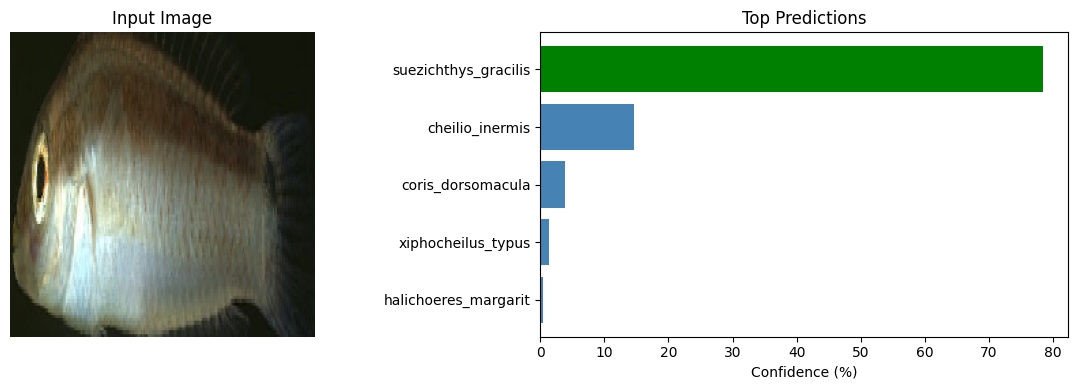


Top 5 Predictions
Correct Actual Species: suezichthys_gracilis, Predicted Species: suezichthys_gracilis, Confidence: 0.78481525182724


In [49]:
test_images = numpy.random.choice(all_images, size=15, replace=False)
model = keras.models.load_model("fish_model.keras")
for image in test_images:
    actual_species = get_species_from_filename(image)
    predicted, confidence = predict_fish(image_path=str(image), model=model)
    if predicted == actual_species:
        correct = "Correct"
    else:
        correct = "Wrong"
    print(f"{correct} Actual Species: {actual_species}, Predicted Species: {predicted}, Confidence: {confidence}")

In [ ]:
model.evaluate(val_dataset)

28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 159ms/step - accuracy: 0.5465 - loss: 2.2029
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 159ms/step - accuracy: 0.3639 - loss: 3.1192


[3.119220733642578, 0.3639455735683441]